### The Integral Model

Wilson-Cowan-Amari neural field equation:

$$\frac{\partial u(\textbf{x},t)}{\partial t} = - u(\textbf{x},t) + \int_{\Omega} W(\textbf{x},\textbf{y})f(u(\textbf{y}, t)) d\sigma(\textbf{y}),$$

where $\Omega \subset \mathbb{R} ^2, $$u(x,t)$ is the synaptic potential, $W(x,y)$ the synaptic connectivity and $f(u)$ a nonlinear function for the conversion of the synaptic potential into a firing rate. In general, both $W$ and $f$ depend upon control parameters which we will define later.

$$ W(\textbf{x},\textbf{y}) = w(||\textbf{x}-\textbf{y}||)\\$$

### Choices for the Connectivity Kernel and Firing Rate Function:

The Connectivity Kernel and Firing Rate Function are objects that receive the Parameters on their Constructors and can be evaluated using the evaluateAt() function. i.e: object.evaluateAt(x).

They are defined as:

Connectivity Kernel1: 

$$ W(\textbf{x};b) = \frac{1}{2} e^{-b||\textbf{x}||}\\$$
Connectivity Kernel2:

$$ W(\textbf{x}; b) = e^{-b||\textbf{x}||}(b \sin{||\textbf{x}||} + \cos{||\textbf{x}||}) \\$$
Here, $b$ controls the decay of the Synaptic Kernel.

Firing Rate1:

$$ f(u; \mu, \theta) = \frac{1}{1+exp(-\mu(u-\theta))} \\$$
Firing Rate2:

$$ f(u; \mu, \theta) = \frac{1}{1+e^{-\mu u + \theta}} - \frac{1}{1+e^\theta}\\$$
Here, $\mu$ controls the slope of the sigmoidal firing rate, and $\theta$ is a threshold value.

In [1]:
from math import *
import numpy as np
from scipy.integrate import ode
from getWeightsPoints import getWeightsAndPoints
import InitialConditions as ic
import FiringRate as fr
import ConnectivityKernel as ck
import NeuralField as nf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Spatial Grid
Nx = 20 # Number of points in the x space grid
Lx = -30; Ux = 30 # x-space grid limits  
xi = np.linspace(Lx, Ux, Nx) # nx equally spaced points between -Lx and Lx
hx = xi[1] - xi[0]

In [3]:
Np = 3 # Desired number of gauss points.
wgts, pts = getWeightsAndPoints(Np)
Ng = len(wgts) # Actual Number of Gauss points.
print("Gauss Weights: "+str(wgts))
print("Gauss Points: "+str(pts))

Gauss Weights: [ 0.55555556  0.88888889  0.55555556]
Gauss Points: [-0.77459667  0.          0.77459667]


In [4]:
wgts_h = (hx/2)*wgts
g_wgts = np.tile(wgts_h, Nx-1)
wts_o = np.outer(g_wgts.T, g_wgts)
g_wts = wts_o.flatten()

In [5]:
N = (Nx-1)*Ng

# Linear Grid of Interior (x,y) points i.e. (x_{is}, x_{jt})
grid = []
for i in range(Nx-1):
    x = xi[i]
    for s in range(Ng):
        int_x = x + (hx/2)*(1+pts[s])
        for j in range(Nx-1):
            y = xi[j]
            for t in range(Ng):
                int_y = y + (hx/2)*(1+pts[t])
                new_pt = np.array([int_x, int_y])
                grid.append(new_pt)
grid = np.array(grid)
N_sq = len(grid)

In [6]:
# Initialize Connectivity Kernel
b = 0.4
kernel = ck.ConnectivityKernel2(b)

In [8]:
%%time
# Assemble Synaptic Matrix

W = np.zeros( (N_sq,N_sq) )

# Compute only the upper triangular part
for i in range(0, N_sq):
    x_pt=grid[i]
    for j in range(i, N_sq):
        y_pt = grid[j]
        x, y = x_pt-y_pt
        W[i,j] = kernel(x, y)
        
# Copy upper triangular part to lower triangular part
i_lower = np.tril_indices(N_sq, -1)
W[i_lower] = W.T[i_lower]

# Multiply times the weights
W *= g_wts
del g_wts

print(W.shape)

Computing Synaptic Matrix ...
(3249, 3249)


### Time step using standard ODE solvers

In [9]:
# Parameters for Firing Rate
mu = 3.4; theta = 5.6;
f_rate = fr.FiringRate2(mu, theta)

# Initialize Neural Field
neuralField = nf.NeuralField(f_rate, W)

In [10]:
# Initial Conditions
#_A = 6; _L = 5.77 # parameters for initial condition 1
_A = 2; _L = 100 # parameters for initial condition 2
initCond = ic.InitialCondition2(_A, _L)

u0 = []
for point in grid:
    x, y = point
    u0.append( initCond(x, y) )
u0 = np.array(u0)

In [11]:
method = ode(neuralField).set_integrator("dopri5")
method.set_initial_value(u0)
final_t = 50
dt = 0.1
us = []
time_points = []
while method.t < final_t:
    next_t = method.t+dt
    time_points.append(next_t)
    next_u = method.integrate(next_t)
    us.append(next_u)

### Plot Solutions

In [12]:
xs = grid[0::N+1,0];
ys = grid[0:N,1];
xx,yy = np.meshgrid(xs, ys)

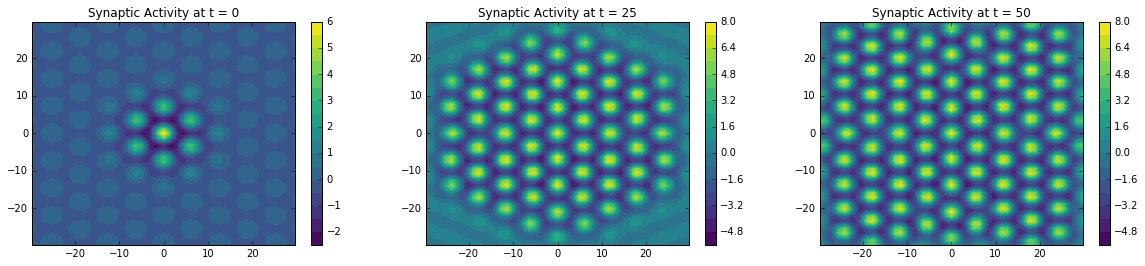

In [13]:
fig = plt.figure(figsize=(20,4))

# Plot initial time
ax1 = fig.add_subplot(131)
uu0 = u0.reshape(( (Nx-1)*Ng,(Nx-1)*Ng)).T
cont1 = ax1.contourf(xx, yy, uu0, 20, cmap=plt.get_cmap('viridis'))
ax1.set_title("Synaptic Activity at t = 0")
plt.colorbar(cont1)

# Plot half time
ax2 = fig.add_subplot(132)
un_2 = us[int(len(time_points)/2)].reshape(( (Nx-1)*Ng,(Nx-1)*Ng)).T
cont2 = ax2.contourf(xx, yy, un_2, 20, cmap=plt.get_cmap('viridis'))
ax2.set_title("Synaptic Activity at t = "+str(int(final_t/2)))
plt.colorbar(cont2)

# Plot final time
ax3 = fig.add_subplot(133)
un = us[-1].reshape(( (Nx-1)*Ng,(Nx-1)*Ng)).T
cont3 = ax3.contourf(xx, yy, un, 20, cmap=plt.get_cmap('viridis'))
ax3.set_title("Synaptic Activity at t = "+str(final_t))
plt.colorbar(cont3)
plt.savefig("Plots/IC"+str(initCond.num)+"/IC"+str(initCond.num)+"_"+str(N**2)+"points_("+str(mu)+")mu.png")